In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
import os
import random
import shutil
!pip install -q visualkeras
!pip install -q tf-keras-vis matplotlib
import visualkeras
import matplotlib.pyplot as plt
from sklearn import metrics
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import BinaryScore
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [16]:
def load_images(image_paths, size=(224, 224)):
    images = []
    labels = []
    
    for path, label in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, size)
        img = img_to_array(img)
        images.append(img)
        labels.append(label)
        
    images = np.array(images, dtype="float32")
    labels = np.array(labels)
    
    images = preprocess_input(images)
    
    return images, labels

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = './dataset/train'
test_dir = './dataset/test'

batch_size = 64
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2  # Set aside a validation subset
)
test_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.99  # Set aside a validation subset
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), 
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), 
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224), 
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 19800 images belonging to 2 classes.


Epoch 1/5
300/300 [==============================] - 311s 1s/step - loss: 0.4891 - accuracy: 0.7821 - val_loss: 118.0205 - val_accuracy: 0.5004
Epoch 2/5
300/300 [==============================] - 284s 949ms/step - loss: 0.4041 - accuracy: 0.8226 - val_loss: 124.0013 - val_accuracy: 0.4990
Epoch 3/5
300/300 [==============================] - 293s 976ms/step - loss: 0.3796 - accuracy: 0.8375 - val_loss: 45.4043 - val_accuracy: 0.4998
Epoch 4/5
300/300 [==============================] - 287s 956ms/step - loss: 0.3627 - accuracy: 0.8432 - val_loss: 23.4208 - val_accuracy: 0.4984
Epoch 5/5
300/300 [==============================] - 134s 445ms/step - loss: 39.7190 - accuracy: 0.4998
Test Accuracy: 49.98%


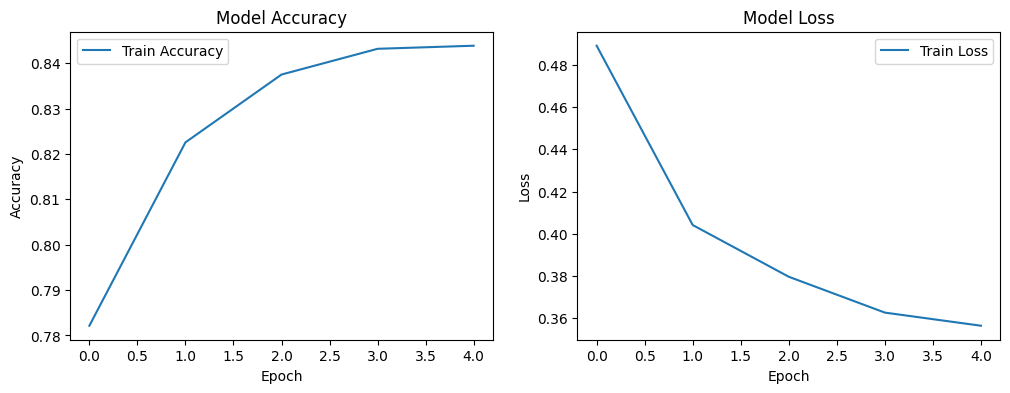

In [19]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-50]:  # Freeze all but last 50 layers
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

steps_per_epoch = 300
validation_steps = 300

with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        epochs=5
    )

test_loss, test_acc = model.evaluate(validation_generator, steps=validation_steps)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [40]:

actual = []
predicted = []
for images,labels in test_generator:
    preds = model.predict(images, verbose = 0)
    predicted.extend((preds > 0.5).astype(int).flatten())
    actual.extend(labels)
    

confusion_matrix = metrics.confusion_matrix(actual, predicted)
confusion_matrix_transposed = confusion_matrix.T

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_transposed, display_labels=[0, 1])
cm_display.plot(cmap=plt.cm.Reds)
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.show()

KeyboardInterrupt: 

Epoch 1/5
300/300 [==============================] - 415s 1s/step - loss: 0.2781 - accuracy: 0.8883 - val_loss: 0.2118 - val_accuracy: 0.9216
Epoch 2/5
300/300 [==============================] - 370s 1s/step - loss: 0.1841 - accuracy: 0.9286 - val_loss: 0.1573 - val_accuracy: 0.9404
Epoch 3/5
300/300 [==============================] - 335s 1s/step - loss: 0.1632 - accuracy: 0.9374 - val_loss: 0.1744 - val_accuracy: 0.9273
Epoch 4/5
300/300 [==============================] - 333s 1s/step - loss: 0.1484 - accuracy: 0.9419 - val_loss: 0.1853 - val_accuracy: 0.9284
Epoch 5/5
300/300 [==============================] - 147s 488ms/step - loss: 0.1368 - accuracy: 0.9478
Test Accuracy: 94.78%


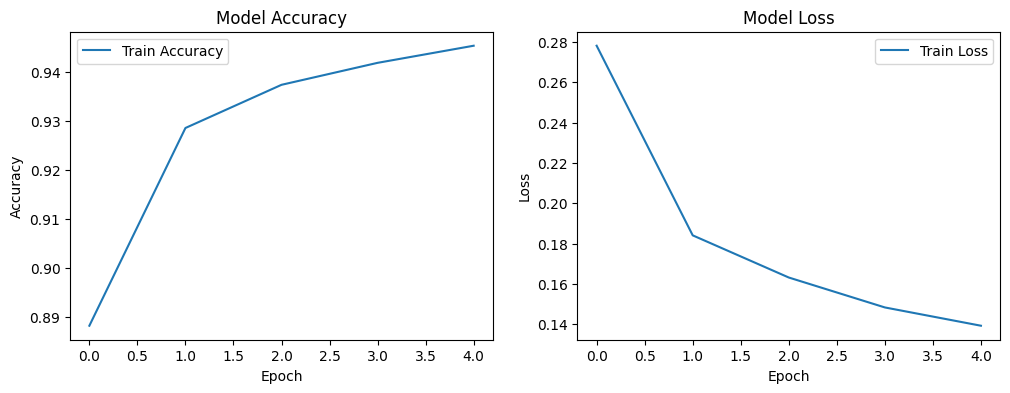

In [41]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-50]:  # Freeze all but last 50 layers
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

steps_per_epoch = 300
validation_steps = 300

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=5
)

test_loss, test_acc = model.evaluate(validation_generator, steps=validation_steps)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

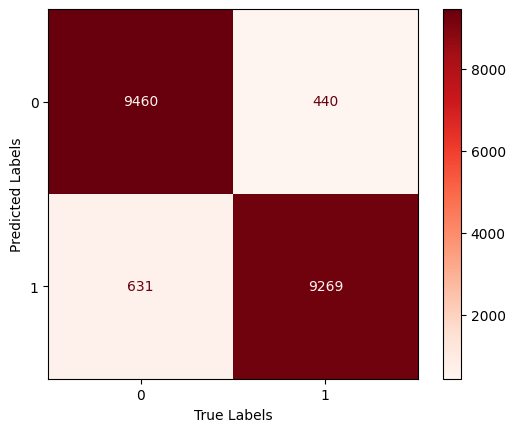

In [ ]:
# Compute and display confusion matrix
preds = model.predict(test_generator, verbose=0)
actual = test_generator.labels  
predicted = (preds > 0.5).astype(int).flatten()

confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])
cm_display.plot(cmap=plt.cm.Reds)
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.show()


In [50]:
steps = len(test_generator)
print(steps)

310


1/1 [==============================] - 0s 28ms/step


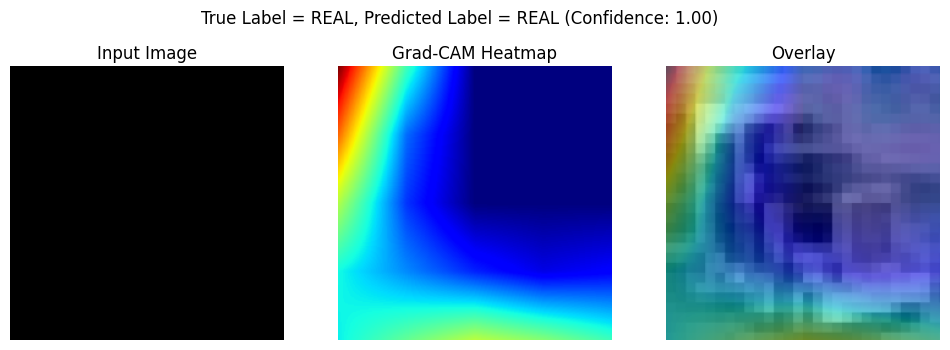

1/1 [==============================] - 0s 30ms/step


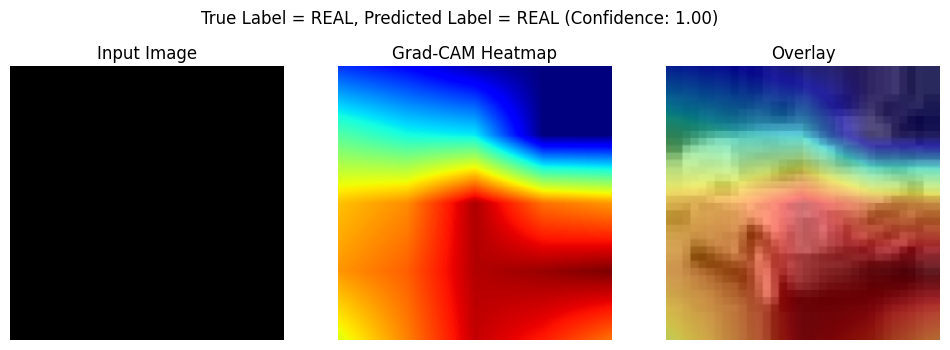

1/1 [==============================] - 0s 23ms/step


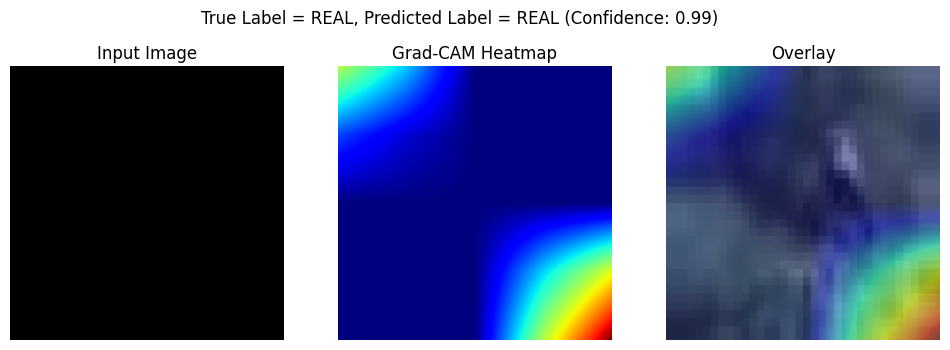

1/1 [==============================] - 0s 29ms/step


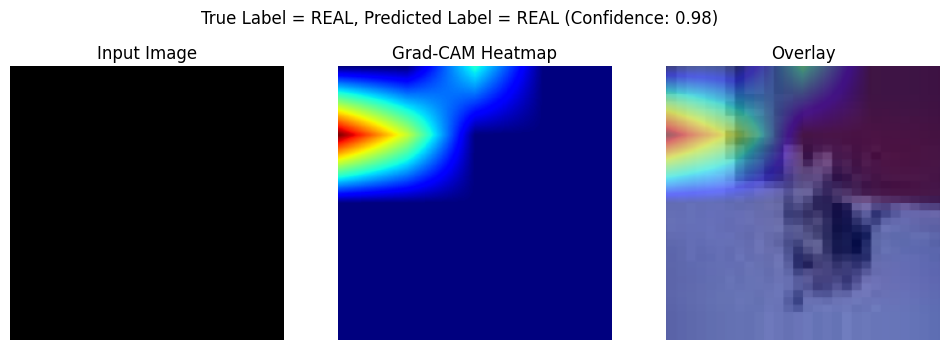

1/1 [==============================] - 0s 27ms/step


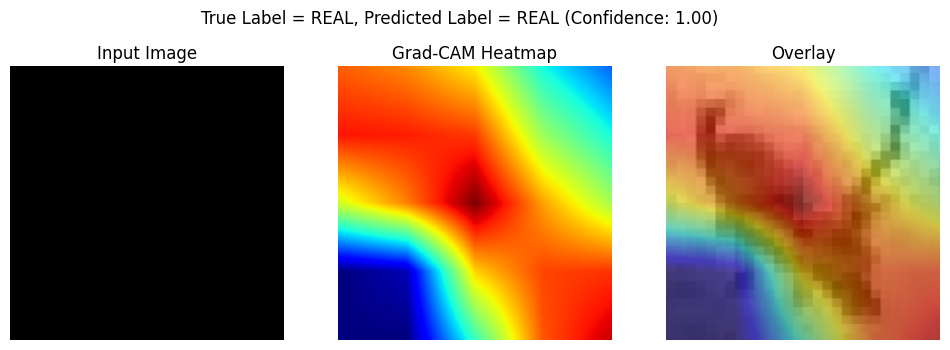

In [52]:
gradcam = Gradcam(model, clone=True)

def binary_score_function(output):
    return output[..., 0]

steps = len(test_generator)  # Total number of batches

# Iterate over the generator for a fixed number of steps
for i in range(200):
    images, labels = next(test_generator) #you can rerun cell to get more, individuals not so important as in aggregate
    cam_images = images[:5]
    cam_labs = labels[:5]

for i in range(len(cam_images)):
    input_image = cam_images[i]
    input_lab = cam_labs[i]

    pred_lab = model.predict(tf.expand_dims(input_image, axis=0))[0][0] #model predicted labels, rounded
    pred_class = 'REAL' if pred_lab > 0.5 else 'FAKE'
    true_class = 'REAL' if input_lab == 1 else 'FAKE'

    cam = gradcam(binary_score_function, tf.expand_dims(input_image, axis=0))[0] #actually making the cam

    heatmap = np.uint8(255 * cam)
    overlay = tf.keras.utils.array_to_img(input_image).convert("RGBA")
    heatmap_img = plt.cm.jet(heatmap)[..., :3] * 255
    heatmap_overlay = tf.keras.utils.array_to_img(np.uint8(heatmap_img)).convert("RGBA")
    blended = tf.keras.utils.img_to_array(overlay).astype("uint8")
    blended[..., :3] = (blended[..., :3] * 0.5 + heatmap_img * 0.5).astype("uint8")

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f'True Label = {true_class}, Predicted Label = {pred_class} (Confidence: {pred_lab:.2f})')

    axes[0].imshow(input_image.astype('uint8')) #original
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    axes[1].imshow(cam, cmap='jet') #cam 
    axes[1].set_title('Grad-CAM Heatmap')
    axes[1].axis('off')

    axes[2].imshow(blended) #cam overlaid on input
    axes[2].set_title('Overlay')
    axes[2].axis('off')

    plt.show()